# Проект по анализу факторов оттока клиентов для банка "Метанпром"


Перед банком "Метанпром" встала задача уменьшить отток клиентов. Уровень оттока клиентов, как мы увидим, позднее порядка 18%. Как мы увидим в дальнейшем, две группы - "отточные" и "неотточные" клиенты довольно заметно отличаются друг от друга. Так например, если в группе "отточные" вероятность встретить мужчину равна примерно 0.65%, то среди неотточных она не сильно отличается от среднестатистических показателей, будучи равна примерно 0.5. Довольно серьезно отличаются и такие показатели как имущество, количество продуктов, активность. Ниже будут даны более подробные количественные сравнения между двумя группами.   

План проекта:

I. Выгрузка и общий анализ датасета:

- импорт библиотек для работы
- загрузка датасета и составление общего представления об имеющихся данных

II. Предобработка данных

- приведение данных к единому формату
- проверка и обработка, если требуется, пропущенных значений
- проверка соответствия типов данных самим данным
- проверка на наличие дубликатов;
- проверка на наличие выбросов и аномалий;
- общий вывод по шагу "Предобработка данных".

III. Исследовательский анализ данных:

- анализ распределения признаков в генеральной совокупности
- сравнение признаков в двух группах — уходящих и остающихся
- сегментация
- выводы и рекомендации

In [1]:
#Импортируем стандартные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime, date, timedelta
import scipy.stats as st
import plotly.express as px
from matplotlib.pyplot import figure
from plotly import graph_objects as go
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
# зададим настройки pandas, регулирующие 
# формат вывода 
pd.set_option('display.notebook_repr_html', False) 
pd.set_option('display.max_columns', 15) 
pd.set_option('display.max_rows', 15) 
pd.set_option('display.width', 80) 
pd.options.display.max_colwidth = 130
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
#Загрузим датафрейм
path = "https://drive.google.com/uc?export=download&id=1-U61mhTz_N1ARjy2XSAZ7IlQqGjeqP0F"
banks = pd.read_csv(path)
try:
    df = pd.read_csv(path)
    
except FileNotFoundError:
    print("File not found.")
except pd.errors.EmptyDataError:
    print("No data")
except pd.errors.ParserError:
    print("Parse error")
except Exception:
    print("Other exceptions")


In [4]:
banks.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.000,Рыбинск,Ж,25.000,1,59214.820,2,0,1,75719.140,1
1,146556,861.000,Рыбинск,Ж,37.000,5,850594.330,3,1,0,86621.770,0
2,120722,892.000,Рыбинск,Ж,30.000,0,NaN,1,1,1,107683.340,0
3,225363,866.000,Ярославль,Ж,51.000,5,1524746.260,2,0,1,174423.530,1
4,157978,730.000,Ярославль,М,34.000,5,174.000,1,1,0,67353.160,1


In [5]:
banks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


Есть довольно много пропусков в столбце balance. 

## Предобработка данных

### Приведение названий к единому стандарту

In [6]:
banks.columns = banks.columns.str.lower()

### Обработка пропусков

In [7]:
print('Несложно видеть, что единственной колонкой с пропусками является баланс.\n При этом отсутствует практически четверть значений({0}%)'.format(100*len(banks[banks['balance'].isna()])/len(banks)))  

Несложно видеть, что единственной колонкой с пропусками является баланс.
 При этом отсутствует практически четверть значений(22.95%)


Проверим, есть ли какие-либо интересные особенности у строк с пропуском баланса. 

In [9]:
banks[banks['balance'].isna() == True].head(10)

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
2,120722,892.000,Рыбинск,Ж,30.000,0,NaN,1,1,1,107683.340,0
9,133130,906.000,Ярославль,Ж,67.000,0,NaN,1,0,1,238055.530,0
10,148929,927.000,Ростов,М,52.000,0,NaN,1,1,1,196820.070,0
11,172184,921.000,Ростов,М,41.000,0,NaN,1,1,1,217469.480,0
19,127034,922.000,Рыбинск,Ж,53.000,0,NaN,1,0,0,147094.820,0
21,177415,896.000,Рыбинск,Ж,47.000,0,NaN,1,0,0,225060.350,0
30,155730,946.000,Ярославль,Ж,47.000,0,NaN,2,1,1,660015.850,0
34,205226,944.000,Ярославль,М,35.000,0,NaN,2,1,1,239843.390,0
39,173175,924.000,Рыбинск,Ж,51.000,0,NaN,1,1,1,248844.470,0
43,228585,956.000,Ростов,М,41.000,0,NaN,1,1,0,115117.100,0


In [10]:
banks[banks['balance'].isna() == True].tail(10)

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
9951,162571,712.000,Ярославль,М,37.000,0,NaN,1,1,1,153658.920,0
9964,148232,968.000,Ярославль,Ж,32.000,0,NaN,1,1,0,520631.220,0
9966,120996,908.000,Рыбинск,Ж,68.000,0,NaN,1,1,1,146253.810,0
9969,123120,910.000,Ярославль,Ж,64.000,0,NaN,2,1,1,165340.000,0
9974,160702,919.000,Рыбинск,М,26.000,0,NaN,1,1,1,187423.660,0
9976,208085,876.000,Ростов,М,38.000,0,NaN,1,0,0,171763.690,0
9984,125941,729.000,Ярославль,Ж,42.000,0,NaN,1,1,1,687538.700,0
9993,219924,884.000,Рыбинск,Ж,36.000,0,NaN,1,1,1,169844.880,0
9996,139170,894.000,Ярославль,М,46.000,0,NaN,1,1,0,196898.290,0
9997,115639,903.000,Ярославль,М,24.000,0,NaN,2,1,1,108905.090,0


In [11]:
# оставим колонки без идентификаторов пользователей
cleaned_df = banks.loc[:, banks.columns != 'userid']

In [12]:
cleaned_df.describe()

,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
count,10000.000,9974.000,10000.000,7705.000,10000.000,10000.000,10000.000,10000.000,10000.000
mean,848.699,42.734,2.628,827794.307,1.870,0.680,0.523,147866.886,0.182
std,65.449,12.180,1.981,1980614.147,0.793,0.466,0.499,139388.511,0.386
min,642.000,18.000,0.000,0.000,0.000,0.000,0.000,2546.300,0.000
25%,802.000,33.000,0.000,295554.160,1.000,0.000,0.000,75251.900,0.000
50%,853.000,40.000,3.000,524272.200,2.000,1.000,1.000,119658.105,0.000
75%,900.000,51.000,4.000,980705.850,2.000,1.000,1.000,174500.542,0.000
max,1000.000,86.000,9.000,119113552.010,5.000,1.000,1.000,1395064.450,1.000


In [13]:
nan_df = cleaned_df[cleaned_df['balance'].isna() == True]

In [14]:
nonan_df = cleaned_df[cleaned_df['balance'].isna() == False]

In [15]:
nan_df.describe()

,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
count,2295.000,2279.000,2295.000,0.000,2295.000,2295.000,2295.000,2295.000,2295.000
mean,865.352,42.093,0.051,NaN,1.162,0.816,0.549,226310.209,0.006
std,89.603,11.942,0.226,NaN,0.403,0.388,0.498,199771.794,0.075
min,642.000,18.000,0.000,NaN,0.000,0.000,0.000,20274.030,0.000
25%,871.000,33.000,0.000,NaN,1.000,1.000,0.000,120347.700,0.000
50%,903.000,40.000,0.000,NaN,1.000,1.000,1.000,174160.680,0.000
75%,922.000,49.000,0.000,NaN,1.000,1.000,1.000,240014.995,0.000
max,990.000,86.000,3.000,NaN,3.000,1.000,1.000,1333687.360,1.000


In [16]:
nonan_df.describe()

,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
count,7705.000,7695.000,7705.000,7705.000,7705.000,7705.000,7705.000,7705.000,7705.000
mean,843.739,42.924,3.395,827794.307,2.081,0.640,0.516,124501.872,0.235
std,55.332,12.244,1.584,1980614.147,0.757,0.480,0.500,104663.538,0.424
min,689.000,18.000,0.000,0.000,1.000,0.000,0.000,2546.300,0.000
25%,801.000,33.000,2.000,295554.160,2.000,0.000,0.000,67551.810,0.000
50%,840.000,40.000,4.000,524272.200,2.000,1.000,1.000,106222.200,0.000
75%,882.000,52.000,5.000,980705.850,2.000,1.000,1.000,155045.670,0.000
max,1000.000,86.000,9.000,119113552.010,5.000,1.000,1.000,1395064.450,1.000


Посмотрим визуально. 

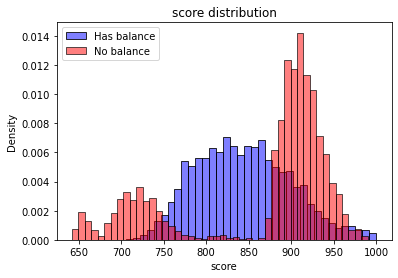

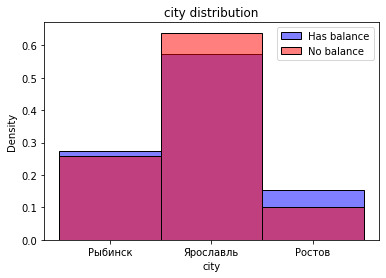

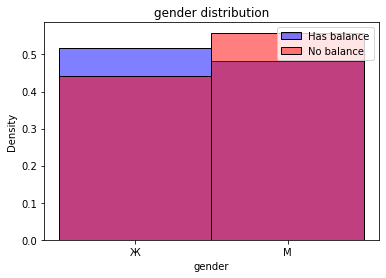

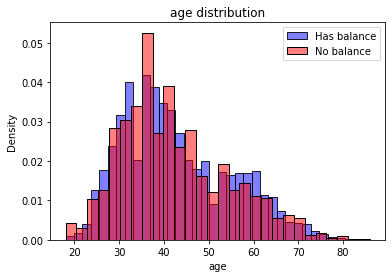

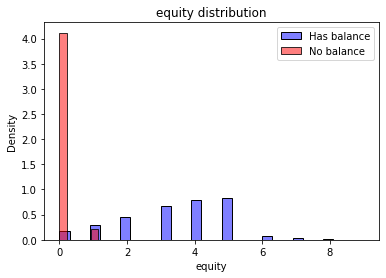

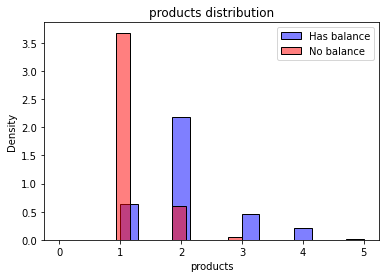

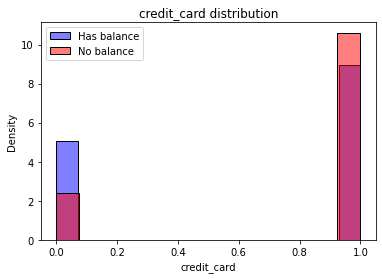

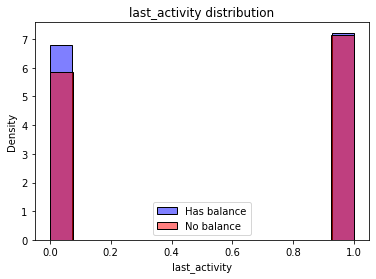

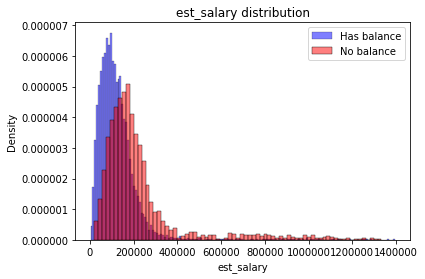

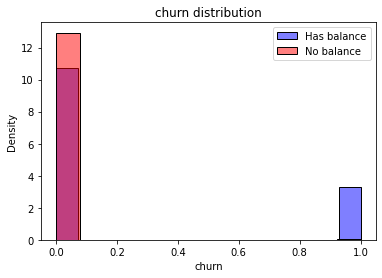

In [17]:
for column in cleaned_df.columns:
    if column != "balance":
      
        sns.histplot(nonan_df[column], alpha=0.5, color="blue", label="Has balance",  stat="density")
        sns.histplot(nan_df[column], alpha=0.5, color="red", label="No balance",  stat="density")
        plt.legend()
        plt.title(f"{column} distribution")
        if column == 'est_salary':
            plt.ticklabel_format(style='plain')
        plt.show()

Итак, на первый взгляд складывается довольно парадоксальная картина. Клиенты без баланса отличаются от клиентов с балансом в нескольких отношениях: 1. Во-первых,  для них среднее количество объектов собственности в 60(!) раз меньше 2. Количество продуктов в 2 раза меньше, и тяготеет к единице. Вероятно, это банковская карта. 3. Их средняя  заработная плата - в два раза больше. 4. Доля клиентов, покинувших банк среди них в 40 раз меньше. 5. Практически у всех клиенты  с пропусками - нет объектов в собственности. 

Пропуски явно не относятся к категории MCAR - совокупности с пропусками и без пропусков очевидным образом отличаются друг от друга. 

При этом стоит отметить, что процент ушедших клиентов отличается на порядок: в группе "без баланса" доля таких клиентов всего полпроцента. Удивительная лояльность. Предположение о том, что это клиенты с "забытыми" картами, тоже не выдерживает критики - по активности эти клиенты не отличаются от остальной совокупности. С учётом такой поразительной привязанности к банку, можно выдвинуть гипотезу, что речь идет о владельцах неких зарплатных карт работающих в организации, обслуживаемой банком. При этом зарплаты в этой организации практически в два раза выше, чем средние региональные зарплаты. Но в этом случае непонятно, почему заявленная собственность у клиентов с пропусками практически всегда нулевая. 

Попробуем посмотреть, можно ли "восстановить" отсутствующий баланс по интуитивно связанным столбцам. Первое что здесь напрашивается - заработная плата. Посмотрим корреляцию между этим показателем и балансом. 

In [18]:
nonan_df['est_salary']. corr(nonan_df['balance'])

0.3396218922125886

Корреляция довольно небольшая. Таким образом, нет смысла пытаться восстановить данные пропуски на основании зарплаты. Пока что приходим к выводу, что у нас собственно, нет точной модели возникновения этих пропусков. Есть гипотезы, вызывающие вопросы. 

В связи с этим можно предположить, что пропуски скорее относятся к категории MNAR, когда отсутствующие данные связаны не только с наблюдаемыми, но и ненаблюдаемыми значениями.  Общий итог - оставляем пропуски без обработки. Возможно, стоит обратиться к заказчику и попросить пояснений. 

### Соответствие данных формату

Несответствия данных не обнаружено.

### Проверка на дубликаты

In [19]:
banks.duplicated().sum()

0

In [20]:
banks = banks.drop_duplicates()

### Аномалии

В связи с аномалиями нас больше всего интересуют две колонки - balance и est. salary. Отбросим аномальные значения.

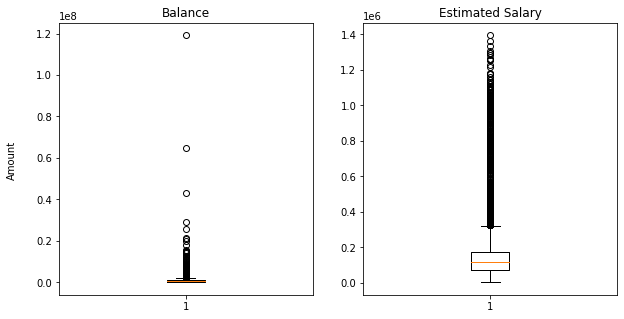

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Create a boxplot for the 'balance' column in the first subplot
ax1.boxplot(nonan_df['balance'])
ax1.set_title('Balance')

# Create a boxplot for the 'est_salary' column in the second subplot
ax2.boxplot(banks['est_salary'])
ax2.set_title('Estimated Salary')

# Set the y-axis label for both subplots
fig.text(0.06, 0.5, 'Amount', ha='center', va='center', rotation='vertical')

# Display the plot
plt.show()

Для баланса напрашивается отсечка в районе 30 000 000

In [22]:
banks_cleared = banks[(banks['balance'] < 30000000) | (banks['balance'].isna()) ]

In [23]:
max_salary = banks['est_salary'].quantile(0.95)

In [24]:
banks_cleared = banks[banks['est_salary'] < max_salary]

In [25]:
len(banks_cleared)

9500

In [26]:
init_total_balance = banks['balance'].sum()

In [27]:
final_total_balance = banks_cleared['balance'].sum()

In [28]:
remaining_per_cent = 100 * final_total_balance/init_total_balance

In [29]:
remaining_per_cent

86.82216227796192

Отсечено в районе 5% аномальных значений и клиенты, располагающие примерно 13% средств на балансе. 

### Обработка категориальных значений

In [30]:
city_dummies = pd.get_dummies(banks_cleared['city'])

In [31]:
banks_cleared = pd.concat([banks, city_dummies], axis=1)

In [32]:
banks_cleared['gender'] = banks_cleared ['gender'].map({'М': 1, 'Ж': 0})

In [33]:
banks_cleared.head()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Ростов,Рыбинск,Ярославль
0,183012,850.000,Рыбинск,0,25.000,1,59214.820,2,0,1,75719.140,1,0.000,1.000,0.000
1,146556,861.000,Рыбинск,0,37.000,5,850594.330,3,1,0,86621.770,0,0.000,1.000,0.000
2,120722,892.000,Рыбинск,0,30.000,0,NaN,1,1,1,107683.340,0,0.000,1.000,0.000
3,225363,866.000,Ярославль,0,51.000,5,1524746.260,2,0,1,174423.530,1,0.000,0.000,1.000
4,157978,730.000,Ярославль,1,34.000,5,174.000,1,1,0,67353.160,1,0.000,0.000,1.000


### Общие выводы к разделу. 

Выявлено довольно большое число пропусков (порядка четверти) в столбце "balance". Однако они относятся, по-видимому, к категории MNAR (совокупность с пропусками имеет статистические отличия от общей совокупности и пропущенные значения определяются ненаблюдаемыми переменными). Устранен один явный дубликат. 

## Исследовательский анализ данных

### Общая картина

Еще раз внимательно посмотрим на общую картину. 

In [34]:
banks_cleared.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,10000.000,171814.713,33708.238,94561.000,142810.250,172728.000,201261.750,229145.000
score,10000.000,848.699,65.449,642.000,802.000,853.000,900.000,1000.000
gender,10000.000,0.500,0.500,0.000,0.000,1.000,1.000,1.000
age,9974.000,42.734,12.180,18.000,33.000,40.000,51.000,86.000
equity,10000.000,2.628,1.981,0.000,0.000,3.000,4.000,9.000
balance,7705.000,827794.307,1980614.147,0.000,295554.160,524272.200,980705.850,119113552.010
products,10000.000,1.870,0.793,0.000,1.000,2.000,2.000,5.000
credit_card,10000.000,0.680,0.466,0.000,0.000,1.000,1.000,1.000
last_activity,10000.000,0.523,0.499,0.000,0.000,1.000,1.000,1.000
est_salary,10000.000,147866.886,139388.511,2546.300,75251.900,119658.105,174500.542,1395064.450


In [35]:
rostov_perc = 0.149
rybinsk_perc = 0.270
yar_perc = 0.583

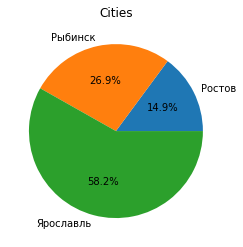

In [36]:
labels = ["Ростов", "Рыбинск", "Ярославль"]
fractions = [rostov_perc, rybinsk_perc, yar_perc]

# Create the pie chart
plt.pie(fractions, labels=labels, autopct='%1.1f%%')

# Set the title
plt.title("Cities")

# Show the plot
plt.show()

Итак, портрет типичного клиента банка:
1. Средний возраст около 43 лет.
2. Кредитный рейтинг - порядка 850.
3. Среднее количество объектов в собственности - около 3
4. Средний баланс - около 800 тыс., при этом медианный заметно меньше - порядка 500 тысяч, что говорит о большом числе выбросов сверху.
5. В среднем клиенты пользуются 2 продуктами. 
6. Средняя зарплата - порядка 150 тыс. рублей.
7. Большая часть клиентов живет в Ярославле. 

In [37]:
### КОД РЕВЬЮЕРА 2
df.groupby("churn").agg(["mean","median"]).T\
  .apply(lambda row: pd.concat((
    row,
    pd.Series(0 if (row[0] == 0 or row[1] == 0) else (row[0]-row[1])/row[0])
    )),axis=1)\
  .set_axis(['Stay','Churn','Change'],axis=1)\
  .query('Change < -.1 or Change > .1')\
  .style.background_gradient(subset=['Change'],cmap='vlag',vmin=-1, vmax=1)\
  .format({'Stay':'{:_.1f}','Churn':'{:_.1f}','Change':'{:.1%}'})

### Различия между ушедшими и остающимися клиентами

Посмотрим, чем различаются остающиеся и ушедшие клиенты.

In [38]:
banks_cleared[banks_cleared['churn']==1].describe()

,userid,score,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Ростов,Рыбинск,Ярославль
count,1820.000,1820.000,1820.000,1819.000,1820.000,1807.000,1820.000,1820.000,1820.000,1820.000,1820.000,1738.000,1738.000,1738.000
mean,170962.346,863.401,0.650,41.450,3.764,1133993.271,2.376,0.551,0.702,148243.010,1.000,0.149,0.245,0.606
std,35289.614,49.612,0.477,11.176,1.586,2033978.249,0.923,0.498,0.457,122914.508,0.000,0.356,0.430,0.489
min,94561.000,706.000,0.000,18.000,0.000,6.000,0.000,0.000,0.000,10880.270,1.000,0.000,0.000,0.000
25%,141300.500,828.000,0.000,32.000,3.000,387218.335,2.000,0.000,0.000,83111.325,1.000,0.000,0.000,0.000
50%,170496.000,866.000,1.000,39.000,4.000,782410.470,2.000,1.000,1.000,125390.620,1.000,0.000,0.000,1.000
75%,201386.250,898.000,1.000,52.000,5.000,1348101.465,3.000,1.000,1.000,175952.932,1.000,0.000,0.000,1.000
max,229058.000,1000.000,1.000,79.000,9.000,64866210.150,5.000,1.000,1.000,1263028.490,1.000,1.000,1.000,1.000


In [39]:
banks_cleared[banks_cleared['churn']==0].describe()

,userid,score,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Ростов,Рыбинск,Ярославль
count,8180.000,8180.000,8180.000,8155.000,8180.000,5898.000,8180.000,8180.000,8180.000,8180.000,8180.000,7762.000,7762.000,7762.000
mean,172004.359,845.428,0.467,43.021,2.375,733982.586,1.758,0.709,0.484,147783.200,0.000,0.147,0.279,0.574
std,33345.469,68.048,0.499,12.375,1.971,1954572.709,0.713,0.454,0.500,142802.379,0.000,0.354,0.449,0.495
min,95384.000,642.000,0.000,18.000,0.000,0.000,1.000,0.000,0.000,2546.300,0.000,0.000,0.000,0.000
25%,143105.500,796.000,0.000,34.000,0.000,279348.670,1.000,0.000,0.000,73506.152,0.000,0.000,0.000,0.000
50%,173218.000,848.000,0.000,40.000,3.000,475382.445,2.000,1.000,0.000,118257.715,0.000,0.000,0.000,1.000
75%,201260.250,900.000,1.000,51.000,4.000,853926.943,2.000,1.000,1.000,173990.125,0.000,0.000,1.000,1.000
max,229145.000,1000.000,1.000,86.000,9.000,119113552.010,5.000,1.000,1.000,1395064.450,0.000,1.000,1.000,1.000


Бросаются в глаза различия по полу - в отточной группе вероятность встретить мужчину практически в два раза выше, чем женщину, между тем как в неотточной группе соотношения между мужчинами и женщинами - стандартное, половина на половину.. Такие ж заметные отличия по собственности  - количество объектов во владении в отточной группе в полтора раза больше, чем в неотточной. Отличия того же порядка есть и в таких категориях как баланс, количество продуктов, доля активных пользователей. На фоне этого - любопытно, что по зарплате эти совокупности не очень различаются между собой. По городам особых отличий нет. 

Посмотрим на диаграммах

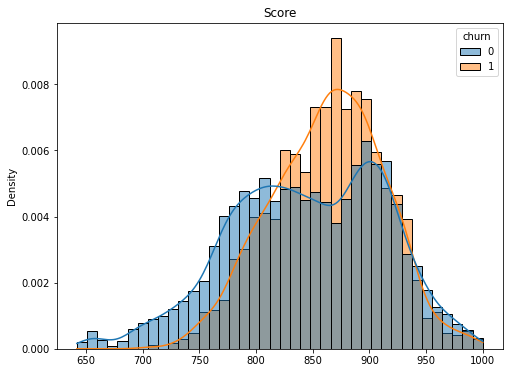

In [40]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(banks_cleared, x='score', hue='churn', ax=ax, kde=True, stat="density", common_norm=False)
ax.set_title('Score')
ax.set_xlabel('')
plt.show()

Довольно заметные отличия по рейтингу между двумя группами. В группе "отточные" есть значительная концентрация пользователей в интервале рейтинга от 830 до 950.

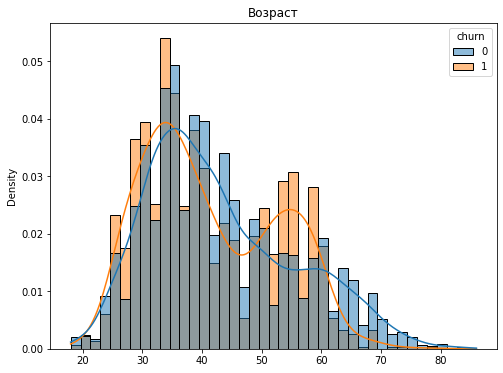

In [41]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(banks_cleared, x='age', hue='churn', ax=ax, kde=True, stat="density", common_norm=False)
ax.set_title('Возраст')
ax.set_xlabel('')
plt.show()

Можно выделить две группы, особенно склонные к уходу - люди до 35 лет и люди старше 50.

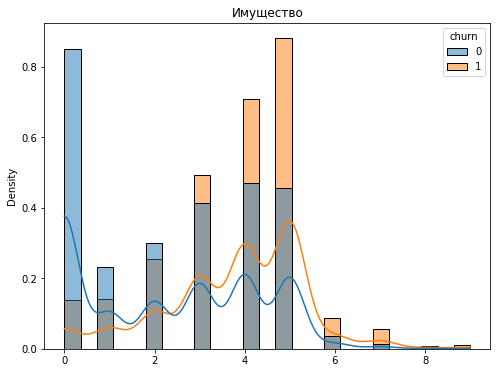

In [42]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(banks_cleared, x='equity', hue='churn', ax=ax, kde=True, stat="density", common_norm=False)
ax.set_title('Имущество')
ax.set_xlabel('')
plt.show()

Клиенты с количеством продуктов 0-1 явно имеют меньшую склонность к уходу, чем клиенты с количеством продуктов от 4.

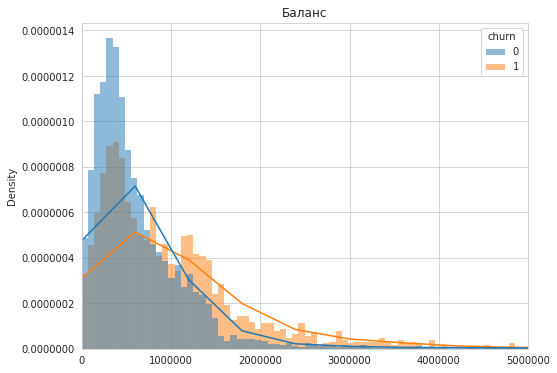

In [43]:
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(banks_cleared, x='balance', hue='churn', ax=ax, kde=True, stat="density", common_norm=False)
ax.ticklabel_format(style='plain', axis='both')
ax.set_title('Баланс')
ax.set_xlabel('')
ax.set_xlim([0, 5000000])
plt.show()

В интервале от 1,5 млн. рублей до по крайней мере 5 млн. у клиентов повышается склонность к уходу. 

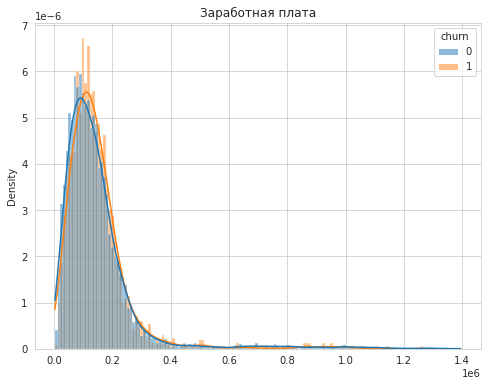

In [44]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(banks_cleared, x='est_salary', hue='churn', ax=ax, kde=True, stat="density", common_norm=False)
ax.set_title('Заработная плата')
ax.set_xlabel('')
plt.show()

Здесь, похоже, особых отличий нет.

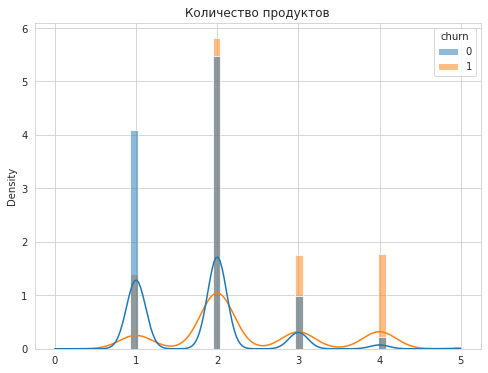

In [45]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(banks_cleared, x='products', hue='churn', ax=ax, kde=True, stat="density", common_norm=False)
ax.set_title('Количество продуктов')
ax.set_xlabel('')
plt.show()

У клиентов с количеством продуктов от 3 до 4 явно больше склонность к уходу. 

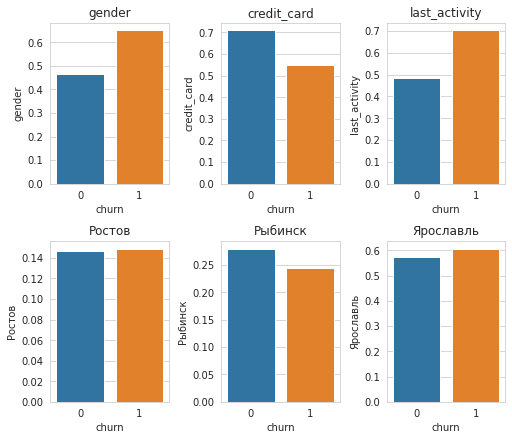

In [46]:

columns_cat = ['gender', 'credit_card', 'last_activity', 'Ростов', "Рыбинск", "Ярославль", 'churn']

churn_grouping = banks_cleared[columns_cat].groupby('churn').mean()
            

fig, axes = plt.subplots(2, 3, figsize=(7, 6), constrained_layout=True)
axes = axes.ravel()

for sign, ax in zip(churn_grouping.columns, axes):
    ax.set_title(sign)
    ax=sns.barplot(data=churn_grouping, x=churn_grouping.index, y=sign, ax=ax)

In [47]:
churn_grouping

,gender,credit_card,last_activity,Ростов,Рыбинск,Ярославль
churn,,,,,,
0,0.467,0.709,0.484,0.147,0.279,0.574
1,0.650,0.551,0.702,0.149,0.245,0.606


Как видно по диаграммам количественным признаков, уходят клиенты более возрастные, с высоким рейтингом, пользующиеся скорее несколькими продуктами, обладающие скорее несколькими объектами имущества. А вот низкий баланс больше располагает к уходу, чем крупный. Что касается категориальных признаков - мужчины более расположены к уходу чем женщины. Среди уходящих - 65% мужчин. Более активные пользователи - с большей вероятностью уходят. Среди уходящих аж 70% активных пользователей. Владельцы кредитной карты менее склонны к уходу, что не удивительно. Возможно, стоит подумать о том, чтобы о том, чтобы сделать (расширить) линейку продуктов с большей ориентацией на более активную, разборчивую и ресурсную клиентуру. Банально советовать расширять круг владельцев кредитных карт и содействовать увеличению размера баланса - эти два фактора уменьшают вероятность ухода - банк, вероятно, и так стремится увеличить эти два показателя в ходе обычной деятельности. 


#### Матрица корреляции

Составим матрицу корреляции.

In [48]:
cols = ['score', 'age', 'balance', 'est_salary', 'products', 'equity', 'Ростов', 'Ярославль', 'Рыбинск', 'gender']
data = banks_cleared[cols]
corr_matrix = data.corr()

In [49]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)

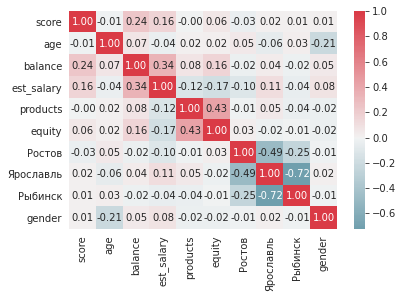

In [50]:
sns.heatmap(corr_matrix, cmap=cmap, center=0, annot=True, fmt=".2f");

В подавляющем большинстве случаев корреляция между признаками либо слабая, либо даже слабо отрицательная, по шкале Чеддока. В двух случаях - между объектами в собственности и количеством продуктов, а также между зарплатой и балансом - умеренная. 

|Показатель |Сравнение портретов|Корреляции|Распределения в разрезе оттока|
|-----------|-------------------|----------|------------------------------|
|неизвестный|есть связь         |нет связи | отточный интервал с __ по __ |
|score      |есть связь         |нет связи | отточный интервал с830 по 950|
|city       |нет связи          |нет связи |                              |
|gender     | есть связь        |нет связи |среди отточных мужчин 65%     |
|age        |есть связь         |нет связи |отток до 35 л. и после 50     |
|equity     |есть связь         |с прод-ми |отточный интервал от 4        |
|balance    |есть связь         |слаб. с з.п.|от 1,5 млн. до 5 млн.       |
|products   |есть связь         |нет        |от 3                         |
|credit_card|есть связь         |          |                              |
|last_activity|есть связь       |          |                              |
|est_salary |нет связи          |слаб.с бсом|                              |
|churn      |                   |          |                              |
|  | | |
    

### Сегментация пользователей

#### Выбор исходной совокупности

Попробуем для начала отсечь достаточно некий "богатый на отточность" кусок датафрейма. Очевидно, он должен соответствовать как минимум двум критериям: 1. Процент отточности должен быть достаточно высоким 2. Сам кусок должен быть достаточно большим. Например, количество продуктов явно не годится в качестве такого признака, поскольку самые отточные сегменты - от 3 до 5 продуктов - невелики по количеству. По этой же причине нецелесообразно отсекать сегмент по имуществу, и категориальным переменным - слишком большие куски совокупности окажутся за бортом. 

Попробуем отсечь по рейтингу. На диаграмме мы видим "отточный" кусок в диапазоне от 830 до 950 баллов.

In [51]:
len(banks_cleared.query('score > 830 & score<950'))

5664

Сравнительно большая совокупность.

In [52]:
score_selected = banks_cleared.query('score > 830 & score<950')

Средняя отточность по всей совокупности у нас равна:

In [53]:
banks['churn'].mean()

0.182

Между тем в выбранном интервале рейтинга она явно выше.

In [54]:
score_selected['churn'].mean()

0.22810734463276836

По диаграммам также видно, что к оттоку  склонны либо более молодые, либо наоборот более возрастные люди. Однако довольно очевидно, что это две очень разные категории, и на них могут влиять разные факторы. Рассмотрим их повнимательнее по отдельности. 

In [55]:
len(score_selected.query('age>=50'))

1607

In [56]:
len(score_selected.query('age>25 & age<=35'))

1734

Довольно крупные по численности, даже в пределах выбранного интервала рейтинга. 

In [57]:
score_and_age_selected_less35 = score_selected.query('age>25 & age<=35')

In [58]:
score_and_age_selected_morethan50 = score_selected.query('age>=50')

<div class="alert alert-warning"><b>Комментарий ревьюера 2</b>&nbsp;🔧<br>
Пожалуйста, используй для разбиения интервалы по возрасту из своего EDA.
</div>

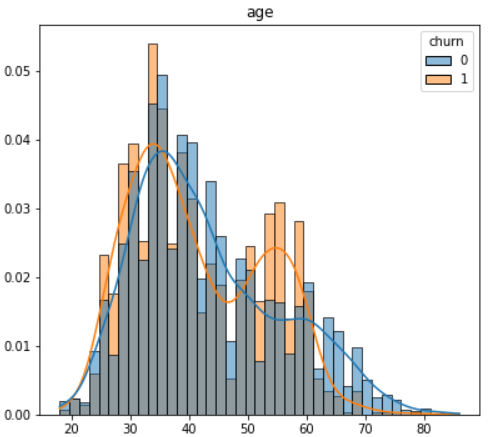

Посмотрим, как у них обстоит дело с отточностью.

In [59]:
score_and_age_selected_morethan50['churn'].mean()

0.20846297448662104

In [60]:
score_and_age_selected_less35['churn'].mean()

0.2918108419838524

Любопытно! В категории "после" процент отточности чуть выше, чем в совокупности в целом, но ниже, чем в подсовокупности "рейтинг от 830 до 950". А вот в категории до 35 - отточность подскакивает почти до 30%! При этом эта категория достаточно многочисленная - 17% от всей  совокупности.

При этом если мы посмотрим на эту возрастную категорию вне рейтинга, то мы увидим, что отточность там не так уж сильно отличается от среднего.

In [61]:
banks_cleared.query('age<=35')['churn'].mean()

0.211485870556062

Давайте сосредоточимся на категории до 35 лет с рейтингом от 830 до 950 как на самой перспективной.  

Этот сегмент состоит из 1734 человек, коэффициент отточности - порядка 30%.

#### Анализ выбранной совокупности

##### Разрез "имущество - продукты"

In [62]:

# create a pivot table to calculate the churn rate
pivot_table_equity_products = score_and_age_selected_less35.pivot_table\
(values='churn', index='equity', columns='products', aggfunc='mean')


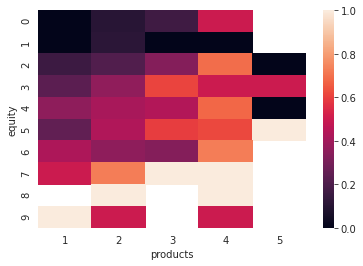

In [63]:
sns.heatmap(pivot_table_equity_products);

Здесь наибольший интерес вызывает диапазон от 2 до 4 продуктов и с количеством объектов имущества от 2. Посмотрим на него повнимательнее. 

In [64]:
len(score_and_age_selected_less35.query\
    (' equity > 1  & products >1 & products < 5 '))

975

Там около 975 человек.

In [65]:
score_and_age_selected_less35.query\
('equity > 1  & products >1 & products < 5')['churn'].mean()

0.4451282051282051

И что самое любопытное - коэффициент отточности подскакивает аж до 44,5%. 

Итак мы видим, что в группе от 25 до 35 лет, с рейтингом от 830 до 950, с количеством продуктов от 2 до 5, с количеством объектов имущества от 2, коэффициент отточности порядка 44,5%. Почти половина. Группа состоит примерно из 1000 человек. 

Запомним этот момент.

##### Разрез "баланс - продукты"

Посмотрим теперь на выбранную совокупность в разрезе баланс - продукты, разделив баланс на 10 интервалов. 

In [66]:
score_and_age_selected_less35_copy = score_and_age_selected_less35.\
query('balance >= 0').copy()

In [67]:
score_and_age_selected_less35_copy['balance_range'] = pd.cut\
(score_and_age_selected_less35_copy['balance'], bins=10)


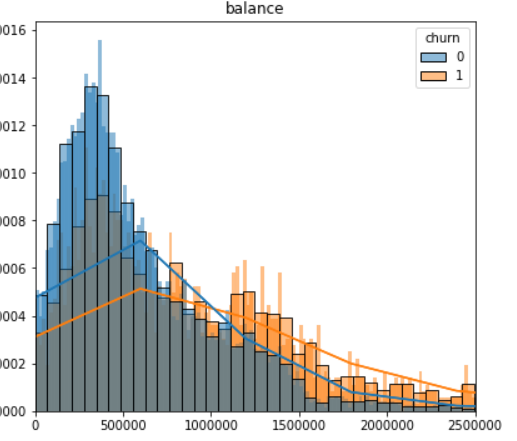

In [68]:
pivot_table_balance_products = score_and_age_selected_less35_copy.\
pivot_table(values='churn', index='balance_range', columns='products', aggfunc='mean')


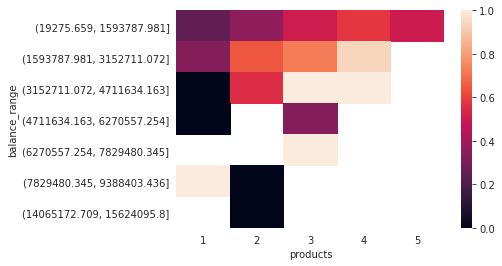

In [69]:
sns.heatmap(pivot_table_balance_products);

In [70]:
len(score_and_age_selected_less35.query\
    ('products >=2 & balance > 1500000 & balance < 5000000'))

112

In [71]:
score_and_age_selected_less35.query('products >=2 & balance > 1500000 & balance < 5000000')\
['churn'].mean()

0.7232142857142857

Итак группа от 25 до 35 лет, с рейтингом от 830 до 950, с количеством продуктов от 2, с балансом от 1,5 млн. до 5 млн. состоит из 110 человек. Однако коэффициент отточности у неё поразительный - около 72%. 

##### Разрез "баланс - имущество"

Теперь обратимся к разрезу баланс - имущество.

In [72]:
pivot_table_balance_equity = score_and_age_selected_less35_copy.pivot_table\
(values='churn', index='balance_range', columns='equity', aggfunc='mean')

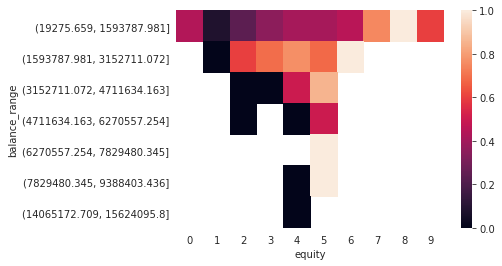

In [73]:
sns.heatmap(pivot_table_balance_equity);

In [74]:
len(score_and_age_selected_less35.query('balance>1500000 & balance < 5000000 & equity > 1'))

117

In [75]:
score_and_age_selected_less35.query('balance>1500000 & balance < 5000000 & equity > 1')['churn'].mean()

0.7094017094017094

Итак группа от 25 до 35 лет, с рейтингом от 830 до 950, с количеством имущественных объектов от 2, с балансом от 1,5 млн. до 5 млн. состоит из 117 человек, и коэффициент отточности  у неё около 71%. 

Итак мы рассмотрели три группы: 
1. Группа от 25 до 35 лет, с рейтингом от 830 до 950, с количеством продуктов от 2 до 5, с количеством объектов имущества от 2, коэффициент отточности порядка 44,5%. Почти половина. Группа состоит примерно из 1000 человек. 
2. Группа от 25 до 35 лет, с рейтингом от 830 до 950, с количеством продуктов от 2, с балансом от 1,5 млн. до 5 млн. состоит из 110 человек. Однако коэффициент отточности у неё около 72%.
3. Группа от 25 до 35 лет, с рейтингом от 830 до 950, с количеством имущественных объектов от 2, с балансом от 1,5 млн. до 5 млн. состоит из 117 человек, и коэффициент отточности  у неё около 71%. 
В целом, это подтверждает наш вывод о том, что наибольшую склонность к уходу проявляют разборчивые, ресурсные и активные клиенты (добавим еще молодые). А кроме того, можно предположить, что с точки зрения размера баланса, есть некая зона большого риска в районе примерно от 1,5 млн до 5 млн рублей. Возможно, банку следует подумать о том, как поощрить клиента максимально быстро проходить эту "опасную" зону с точки зрения размера баланса.  

### Выводы к разделу

<AxesSubplot:ylabel='churn'>

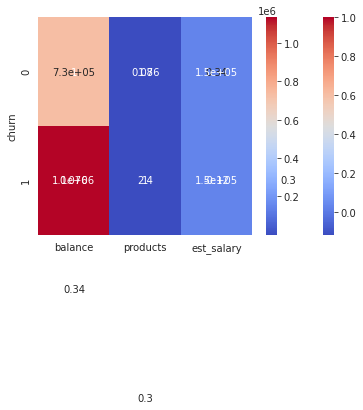

In [76]:
# Create a subset of the dataframe with the relevant columns
subset = banks_cleared[['balance', 'products', 'est_salary', 'churn']]

# Use the `corr()` function to compute the correlation matrix
corr_matrix = subset.corr()

# Use the `heatmap()` function from the Seaborn library to plot the correlation matrix as a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Use the `groupby()` function to group the dataframe by the values in the 'churn' column, and compute the mean values for each group
grouped = subset.groupby('churn').mean()

# Use the `heatmap()` function from the Seaborn library to plot the grouped dataframe as a heatmap
sns.heatmap(grouped, annot=True, cmap='coolwarm')

Определен портрет "среднего" пользователя банка. Человек примерно 43 лет со средней зарплатой порядка 150 тысяч рублей, балансов в 800 тыс. рублей и кредитным рейтингом - около 850. Выявлены статистические отличия между остающимися и уходящими клиентами. Уходят клиенты с высоким рейтингом, пользующиеся скорее несколькими продуктами, обладающие скорее несколькими объектами имущества. А вот низкий баланс больше располагает к уходу, чем крупный. Мвжчины более расположены к уходу чем женщины. Более активные пользователи - с большей вероятностью уходят. Владельцы кредитной карты менее склонны к уходу. Была оценена корреляция между признаками. В подавляющем большинстве случаев корреляция между признаками либо слабая, либо даже слабо отрицательная. В двух случаях - между объектами в собственности и количеством продуктов, а также между зарплатой и балансом - умеренная. Кредитный рейтинг в группах 1 - 4 продуктами несколько выше чем в группах с 2-3 продуктами. Медианный возраст для всех групп - около 40 лет. Для совокупности с четырьмя продуктами - несколько ниже. Чем больше объектов в собственности, тем больше продуктов используется. Наиболее заметные различия между группами в оттоке и возрасте.

## Заключение

Была проведена предварительная обработка данных. Обнаружено большое количество пропусков в столбце "balance". Пропуски, по видимому, относятся к категории MNAR и не подлежат обработке. В разделе "Исследовательский анализ" была рассмотрена как совокупность в целом, так и с разбивкой на две категории - уходящие и остающиеся. Выяснилось, что к уходу более расположены возрастные клиенты, скорее мужчины, чем женщины, скорее активные, чем нет, с более высоким имущественным статусом. Была дана рекомендация делать (расширить) линейку продуктов с большей ориентацией на более активную, разборчивую и ресурсную клиентуру. Кроме того, была проведена сегментация с разбивкой по количеству используемых продуктов. Наиболее заметные различия были выявлены по оттоку и возрасту. 